In [ ]:
%load_ext autoreload
%autoreload 2
import numpy as np
import get_data
import matplotlib.pyplot as plt
import population_activity as pop
import helper_functions as hf
import analysis
import plots
import statistics_test as st

from IPython.display import display, HTML
def print_large(text):
    display(HTML(f"<span style='font-size: 20px;'>{text}</span>"))
    

c:\Users\Ole\anaconda3\envs\spyder-env\lib\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.3, the latest is 0.5.5.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [5]:
datapaths = ['D:/Antje_CA1/data_sig/170.h5', 'D:/Antje_CA1/data_sig/51004.h5', 
             'D:/Antje_CA1/data_sig/51007.h5', 'D:/Antje_CA1/data_sig/63.h5', 
             'D:/Antje_CA1/data_sig/64.h5', 'D:/Antje_CA1/data_sig/65.h5']
maps = [str(i) for i in np.arange(1, 13)] + ['14', '15', '17', '19']
reference = '0'

all_drift_prob = []
all_daily_shifts = []
all_shift_distance = []
all_valid = []
for datapath in datapaths:
    hist_sorts = analysis.sort_maps_from_reference_AK(datapath, 'Context1', reference='0', maps = maps, transients = False, hist='hist')
    drift_prob, daily_shifts, shift_distance, valid = analysis.analyze_place_cell_drift(hist_sorts, 2)
    all_drift_prob.append(drift_prob)
    all_daily_shifts.append(daily_shifts)
    all_shift_distance.append(shift_distance)
    all_valid.append(valid)
prob=np.hstack(all_drift_prob)
    

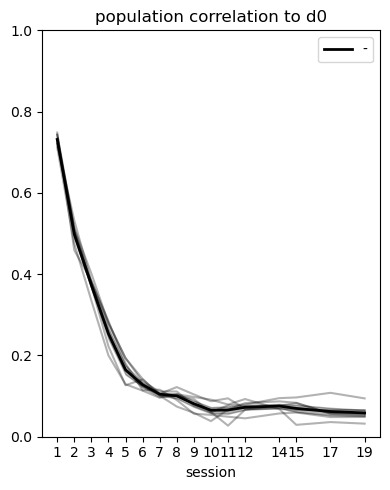

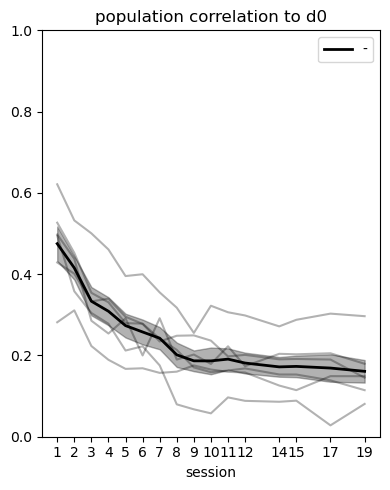

In [6]:
datapaths = ['D:/Antje_CA1/data_sig/170.h5', 'D:/Antje_CA1/data_sig/51004.h5', 
             'D:/Antje_CA1/data_sig/51007.h5', 'D:/Antje_CA1/data_sig/63.h5', 
             'D:/Antje_CA1/data_sig/64.h5', 'D:/Antje_CA1/data_sig/65.h5']
maps = [str(i) for i in np.arange(1, 13)] + ['14', '15', '17', '19']
reference = '0'
normal_correlation_org = []
before_correlation = []
spatial_maps = []
for datapath in datapaths:
    sim = analysis.simulate_drift(
        datapath, 
        session='0',
        Context='Context1',
        days=len(maps)+1,
        max_remap_prob=0.5,
        amplitude_drift_prob=0.4,
        amplitude_change_scale=0.0,
        drift_type='circular',
        dim_red=False,
        standardize='stand',
        odd_even=True,
        global_seed=0,
        active_days=[reference]+maps,
        remove_day_inactive=True,
        drift_probabilities=prob
    )
    corr = [pop.ManifoldAnalysis.population_correlation( maps, sim['maps'][0] ) for maps in sim['maps'] ]
    spatial_maps.append(sim['maps'])
    before_correlation.append(corr[1:])

    hist_sorts = analysis.sort_maps_from_reference_AK(datapath, 'Context1', reference='0', maps = maps, transients = False, hist='hist')
    manifold_reference = hist_sorts[0] 
    manifold_before_rotation = [hist_sorts[day] for day in range(1,len(hist_sorts))]
    normal_correlation = [pop.ManifoldAnalysis.population_correlation(manifold_before_rotation[day], manifold_reference) for day in range(len(manifold_before_rotation))]    
    normal_correlation_org.append(normal_correlation)
fig, ax = plt.subplots(figsize=(4, 5))
plots.plot_average_geometry([before_correlation], maps, colors=['k'], ax=ax, title='population correlation to d0', ylim=[0, 1], labels=['-'])

fig, ax = plt.subplots(figsize=(4, 5))
plots.plot_average_geometry([normal_correlation_org], maps, colors=['k'], ax=ax, title='population correlation to d0', ylim=[0, 1], labels=['-'])


In [7]:
sim_all_drift_prob = []
sim_all_daily_shifts = []
sim_all_shift_distance = []
sim_all_valid = []
for m in spatial_maps:
    drift_prob, daily_shifts, shift_distance, valid = analysis.analyze_place_cell_drift(m, 1)
    sim_all_drift_prob.append(drift_prob)
    sim_all_daily_shifts.append(daily_shifts)
    sim_all_shift_distance.append(shift_distance)
    sim_all_valid.append(valid)


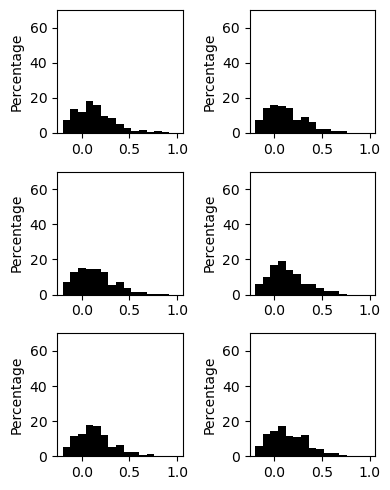

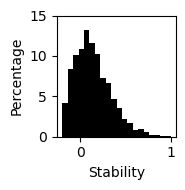

In [10]:
stability_neuron = []
for m in spatial_maps:
    stability_neuron.append(analysis.compute_pairwise_correlations(m))

fig, axs = plt.subplots(3, 2, figsize=(4, 5))

for ax, stab in zip(axs.flatten(), stability_neuron):
    weights = np.ones_like(stab) / len(stab) * 100
    counts, bins, patches = ax.hist(stab, bins=15, range=(-0.2, 1), weights=weights, color='k')
    ax.set_ylim(0, 70)
    ax.set_ylabel('Percentage')

plt.tight_layout()
plt.show()

all_stability = np.concatenate(stability_neuron)
fig, ax = plt.subplots(figsize=(2, 2))
weights = np.ones_like(all_stability) / len(all_stability) * 100
counts, bins, patches = ax.hist(all_stability, bins=20, range=(-0.2, 1), weights=weights, color='k')
ax.set_ylim(0, 15)
ax.set_ylabel('Percentage')
ax.set_xlabel('Stability')
plt.tight_layout()
plt.show()

In [ ]:
def compute_correlation_matrix(datapaths, maps, max_remap_prob, amplitude_drift_prob, amplitude_change_scale, reference='0'):
    # Initialize the 3D correlation matrix
    corr_matrix = np.zeros((
        len(max_remap_prob),
        len(amplitude_drift_prob),
        len(amplitude_change_scale)
    ))
    
    # Counter for averaging
    count = 0
    
    for datapath in datapaths:
        for i, remap in enumerate(max_remap_prob):
            for j, drift in enumerate(amplitude_drift_prob):
                for k, scale in enumerate(amplitude_change_scale):
                    sim = analysis.simulate_drift(
                        datapath, 
                        session='0',
                        Context='Context1',
                        days=len(maps)+1,
                        max_remap_prob=remap,
                        amplitude_drift_prob=drift,
                        amplitude_change_scale=scale,
                        drift_type='circular',
                        dim_red=False,
                        standardize='stand',
                        odd_even=True,
                        global_seed=0,
                        active_days=[reference]+maps,
                        remove_day_inactive=True
                    )
                    
                    corr = pop.ManifoldAnalysis.population_correlation(sim['maps'][0], sim['maps'][-1])
                    corr_matrix[i, j, k] += corr
        
        count += 1
    corr_matrix /= len(datapaths)
    
    return corr_matrix

datapaths = ['D:/Antje_CA1/data_sig/170.h5']#', 'D:/Antje_CA1/data_sig/51004.h5', 
             #'D:/Antje_CA1/data_sig/51007.h5', 'D:/Antje_CA1/data_sig/63.h5', 
             #'D:/Antje_CA1/data_sig/64.h5', 'D:/Antje_CA1/data_sig/65.h5']
maps = [str(i) for i in np.arange(1, 13)] + ['14', '15', '17', '19']
max_remap_prob = np.linspace(0, 1, 6)
amplitude_drift_prob = np.linspace(0, 1, 6)
amplitude_change_scale = [0.6]


correlation_matrix = compute_correlation_matrix(
    datapaths,
    maps,
    max_remap_prob,
    amplitude_drift_prob,
    amplitude_change_scale
)


In [51]:
def analyze_data_common(datapath, reference, maps, analysis_type, method='subspace', compute_day11_12=False, transients=False, dim_red=False, max_dim=4, standardize='stand', max_remap_prob=0.5, amplitude_drift_prob=0.5, amplitude_change_scale=0.6):
    def get_analysis_function(analysis_type):
        if analysis_type == 'population_geometry':
            return analysis.populationgeometry, analysis.populationgeometry_context
        elif analysis_type == 'topology':
            return analysis.topology_analysis, analysis.topology_analysis_context

    analysis_func, context_func = get_analysis_function(analysis_type)

    def apply_analysis(func, *args):
        if analysis_type == 'population_geometry':
            return func(*args, method=method)
        else:
            return func(*args, max_dim=max_dim)

    global_seeds = [1,2,3,4,5]
    simu_g_list = []
    for seed in global_seeds:
        simu_drift = analysis.simulate_drift(datapath, session='0', Context='Context1', days=len(maps)+1, drift_type='circular', 
                                           dim_red=dim_red, standardize=standardize, odd_even=False, global_seed=seed, 
                                           active_days=[reference]+maps, remove_day_inactive=True,
                                           max_remap_prob=max_remap_prob, 
                                           amplitude_drift_prob=amplitude_drift_prob, 
                                           amplitude_change_scale=amplitude_change_scale)
        simu_g = apply_analysis(analysis_func, simu_drift['maps'])
        simu_g_list.append(simu_g)
    simu_g_array = np.array(simu_g_list)
    simu_g = np.mean(simu_g_array, axis=0)
    
    hist_odd, hist_even = analysis.sort_maps_from_reference_within_session_AK(datapath, 'Context1', maps=maps, transients=transients, dim_red=dim_red, standardize=standardize, remove_day_inactive=True)
    g_odd_even1 = apply_analysis(context_func, hist_odd, hist_even)
    if analysis_type == 'population_geometry':      

        shuff1, shuff2 = analysis.shuffle_two_sessions_hist(datapath, '0', '11', 'Context1', dim_red=dim_red, remove_inactive=[reference]+maps, standardize=standardize, remove_day_inactive=True)
        g_shuff1 = apply_analysis(context_func, [shuff1], [shuff2])
        simu_g = (simu_g - np.mean(g_odd_even1)) / (np.mean(g_shuff1) - np.mean(g_odd_even1))
    else:
        simu_g = simu_g- np.mean(g_odd_even1)
    return simu_g

def collect_data(datapaths, reference, maps, analysis_type, method='subspace', compute_day11_12=False, transients=False, 
                 dim_red=False, max_dim=3, standardize='stand', max_remap_prob=0.5, amplitude_drift_prob=0.5, amplitude_change_scale=0.6):
    all_data = []
    for datapath in datapaths:
        data = analyze_data_common(datapath, reference, maps, analysis_type, method=method, 
                                 compute_day11_12=compute_day11_12, transients=transients, 
                                 dim_red=dim_red, max_dim=max_dim, standardize=standardize,
                                 max_remap_prob=max_remap_prob,
                                 amplitude_drift_prob=amplitude_drift_prob,
                                 amplitude_change_scale=amplitude_change_scale)
        all_data.append(data)
    return all_data

if __name__ == "__main__":
    datapaths = ['D:/Antje_CA1/data_sig/170.h5', 'D:/Antje_CA1/data_sig/51004.h5', 'D:/Antje_CA1/data_sig/51007.h5', 
                 'D:/Antje_CA1/data_sig/63.h5', 'D:/Antje_CA1/data_sig/64.h5', 'D:/Antje_CA1/data_sig/65.h5']

    max_remap_prob_list = [0.1, 0.3, 0.6]
    amplitude_drift_prob_list = [0.1, 0.3, 0.6]
    amplitude_change_scale_list = [0.25, 0.5, 0.75]

    transients = False
    dim_red = False
    max_dim = 4

    reference = '0'
    maps = [str(i) for i in np.arange(1, 13)] +  ['14', '15', '17', '19']
    

    results = {
        'max_remap_prob_variation': {
            'pop_geometry_subspace': [],
            'pop_geometry_angles': [],
            'topology': []
        },
        'amplitude_drift_prob_variation': {
            'pop_geometry_subspace': [],
            'pop_geometry_angles': [],
            'topology': []
        },
        'amplitude_change_scale_variation': {
            'pop_geometry_subspace': [],
            'pop_geometry_angles': [],
            'topology': []
        }
    }

    # Vary max_remap_prob
    for max_remap_prob in max_remap_prob_list:
        # forward_data_pop_geometry_subspace = collect_data(datapaths, reference, maps, 'population_geometry', 
        #     method='subspace', compute_day11_12=False, transients=transients, dim_red=dim_red, 
        #     standardize='stand', max_remap_prob=max_remap_prob, amplitude_drift_prob=0.3, amplitude_change_scale=0.5)
        
        forward_data_pop_geometry_angles = collect_data(datapaths, reference, maps, 'population_geometry', 
            method='angles', compute_day11_12=False, transients=transients, dim_red=dim_red, 
            standardize='stand', max_remap_prob=max_remap_prob, amplitude_drift_prob=0.3, amplitude_change_scale=0.5)
        
        # forward_data_topology = collect_data(datapaths, reference, maps, 'topology', 
        #     compute_day11_12=False, transients=transients, dim_red=dim_red, max_dim=max_dim, 
        #     standardize='stand', max_remap_prob=max_remap_prob, amplitude_drift_prob=0.3, amplitude_change_scale=0.5)
        
        # results['max_remap_prob_variation']['pop_geometry_subspace'].append(forward_data_pop_geometry_subspace)
        results['max_remap_prob_variation']['pop_geometry_angles'].append(forward_data_pop_geometry_angles)
        # results['max_remap_prob_variation']['topology'].append(forward_data_topology)

    # Vary amplitude_drift_prob
    for amplitude_drift_prob in amplitude_drift_prob_list:
        # forward_data_pop_geometry_subspace = collect_data(datapaths, reference, maps, 'population_geometry', 
        #     method='subspace', compute_day11_12=False, transients=transients, dim_red=dim_red, 
        #     standardize='stand', max_remap_prob=0.3, amplitude_drift_prob=amplitude_drift_prob, amplitude_change_scale=0.5)
        
        forward_data_pop_geometry_angles = collect_data(datapaths, reference, maps, 'population_geometry', 
            method='angles', compute_day11_12=False, transients=transients, dim_red=dim_red, 
            standardize='stand', max_remap_prob=0.3, amplitude_drift_prob=amplitude_drift_prob, amplitude_change_scale=0.5)
        
        # forward_data_topology = collect_data(datapaths, reference, maps, 'topology', 
        #     compute_day11_12=False, transients=transients, dim_red=dim_red, max_dim=max_dim, 
        #     standardize='stand', max_remap_prob=0.3, amplitude_drift_prob=amplitude_drift_prob, amplitude_change_scale=0.5)
        
        # results['amplitude_drift_prob_variation']['pop_geometry_subspace'].append(forward_data_pop_geometry_subspace)
        results['amplitude_drift_prob_variation']['pop_geometry_angles'].append(forward_data_pop_geometry_angles)
        # results['amplitude_drift_prob_variation']['topology'].append(forward_data_topology)

    # Vary amplitude_change_scale
    for amplitude_change_scale in amplitude_change_scale_list:
        # forward_data_pop_geometry_subspace = collect_data(datapaths, reference, maps, 'population_geometry', 
        #     method='subspace', compute_day11_12=False, transients=transients, dim_red=dim_red, 
        #     standardize='stand', max_remap_prob=0.3, amplitude_drift_prob=0.3, amplitude_change_scale=amplitude_change_scale)
        
        forward_data_pop_geometry_angles = collect_data(datapaths, reference, maps, 'population_geometry', 
            method='angles', compute_day11_12=False, transients=transients, dim_red=dim_red, 
            standardize='stand', max_remap_prob=0.3, amplitude_drift_prob=0.3, amplitude_change_scale=amplitude_change_scale)
        
        # forward_data_topology = collect_data(datapaths, reference, maps, 'topology', 
        #     compute_day11_12=False, transients=transients, dim_red=dim_red, max_dim=max_dim, 
        #     standardize='stand', max_remap_prob=0.3, amplitude_drift_prob=0.3, amplitude_change_scale=amplitude_change_scale)
        
        # results['amplitude_change_scale_variation']['pop_geometry_subspace'].append(forward_data_pop_geometry_subspace)
        results['amplitude_change_scale_variation']['pop_geometry_angles'].append(forward_data_pop_geometry_angles)
        # results['amplitude_change_scale_variation']['topology'].append(forward_data_topology)

In [53]:
def analyze_data_common(datapath, reference, maps, analysis_type, method='subspace', compute_day11_12=False, 
                        transients=False, dim_red=False, max_dim=4, standardize='stand'):
    def get_analysis_function(analysis_type):
        if analysis_type == 'population_geometry':
            return analysis.populationgeometry, analysis.populationgeometry_context
        elif analysis_type == 'topology':
            return analysis.topology_analysis, analysis.topology_analysis_context


    analysis_func, context_func = get_analysis_function(analysis_type)

    def apply_analysis(func, *args):
        if analysis_type == 'population_geometry':
            return func(*args, method=method)
        else:
            return func(*args, max_dim=max_dim)

    hists = analysis.sort_maps_from_reference_AK(datapath, 'Context1', reference=reference, maps=maps, reference_type='no_reference',
                                                  hist='hist', transients=transients, dim_red=dim_red, 
                                                  standardize=standardize, remove_day_inactive=False)
    #hists=hists[::-1] 
    g = apply_analysis(analysis_func, hists)

    hist_odd, hist_even = analysis.sort_maps_from_reference_within_session_AK(datapath, 'Context1', maps=maps, 
                                                                                  transients=transients, dim_red=dim_red,
                                                                                    standardize=standardize, remove_day_inactive=False)
    g_odd_even1 = apply_analysis(context_func, hist_odd, hist_even)

    if analysis_type == 'population_geometry':      

        shuff1, shuff2 = analysis.shuffle_two_sessions_hist(datapath, '0', '19', 'Context1', dim_red=dim_red, remove_inactive=[reference]+maps, 
                                                            standardize=standardize, remove_day_inactive=False)
        g_shuff1 = apply_analysis(context_func, [shuff1], [shuff2])

        
        g = (g - np.mean(g_odd_even1)) / (np.mean(g_shuff1) - np.mean(g_odd_even1))

    else:
        g = g-g_odd_even1

  
    return g


def collect_data(datapaths, reference, maps, analysis_type, method='subspace', compute_day11_12=False, transients=False, dim_red=False, max_dim=3, standardize='stand'):
    all_data = []
    for datapath in datapaths:
        data = analyze_data_common(datapath, reference, maps, analysis_type, method=method, compute_day11_12=compute_day11_12, transients=transients, dim_red=dim_red, max_dim=max_dim, standardize=standardize)
        all_data.append(data)
    return all_data

if __name__ == "__main__":
    datapaths = ['D:/Antje_CA1/data_sig/170.h5', 'D:/Antje_CA1/data_sig/51004.h5', 'D:/Antje_CA1/data_sig/51007.h5', 'D:/Antje_CA1/data_sig/63.h5', 'D:/Antje_CA1/data_sig/64.h5', 'D:/Antje_CA1/data_sig/65.h5']
    transients = False
    dim_red = False
    max_dim = 4

    reference = '0'
    maps = [str(i) for i in np.arange(1, 13)] +  ['14', '15', '17', '19']
    forward_data_pop_geometry_angles = collect_data(datapaths, reference, maps, 'population_geometry', method='angles', compute_day11_12=False, transients=transients, dim_red=dim_red, standardize='stand')

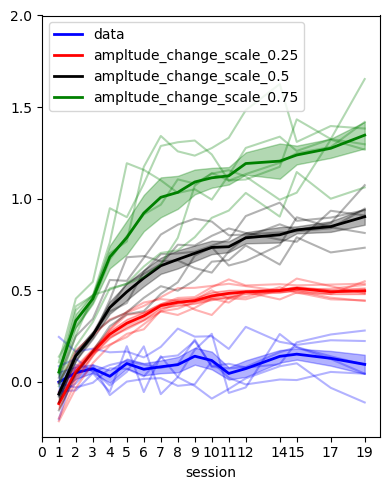

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,time,2.132450,15,75,0.142163,32.502709,1.039292e-26,0.000001,0.657651,0.192068
1,condition,3.613586,1,5,3.613586,112.915756,1.276636e-04,0.000128,0.764997,1.000000
2,time * condition,1.097622,15,75,0.073175,26.420486,6.545005e-24,0.000003,0.497179,0.203223


,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,time,4.336682,15,75,0.289112,47.595760,4.233992e-32,6.240985e-08,0.722854,0.201028
1,condition,12.165925,1,5,12.165925,147.652220,6.671063e-05,6.671063e-05,0.879763,1.000000
2,time * condition,2.767473,15,75,0.184498,39.650822,1.746204e-29,9.345317e-08,0.624686,0.213720


,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,time,7.368963,15,75,0.491264,37.235809,1.342299e-28,4.355085e-08,0.664914,0.232964
1,condition,34.062256,1,5,34.062256,135.824482,8.169515e-05,8.169515e-05,0.901693,1.000000
2,time * condition,5.283924,15,75,0.352262,30.053371,1.222213e-25,2.861656e-07,0.587263,0.228076


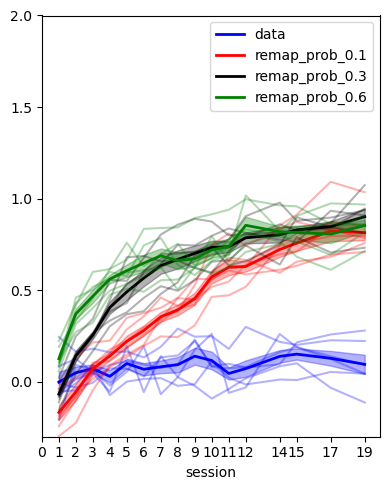

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,time,5.346862,15,75,0.356457,47.247839,5.406574e-32,2.175343e-07,0.760189,0.184072
1,condition,5.184065,1,5,5.184065,85.663398,2.474429e-04,2.474429e-04,0.754507,1.000000
2,time * condition,3.628956,15,75,0.241930,37.391771,1.172665e-28,3.059090e-06,0.682688,0.164954


,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,time,4.336682,15,75,0.289112,47.595760,4.233992e-32,6.240985e-08,0.722854,0.201028
1,condition,12.165925,1,5,12.165925,147.652220,6.671063e-05,6.671063e-05,0.879763,1.000000
2,time * condition,2.767473,15,75,0.184498,39.650822,1.746204e-29,9.345317e-08,0.624686,0.213720


,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,time,2.332980,15,75,0.155532,24.764788,4.662431e-23,2.149868e-07,0.571689,0.261551
1,condition,15.283858,1,5,15.283858,307.330776,1.107302e-05,1.107302e-05,0.897375,1.000000
2,time * condition,1.275140,15,75,0.085009,16.299398,7.770834e-18,3.025858e-05,0.421811,0.215674


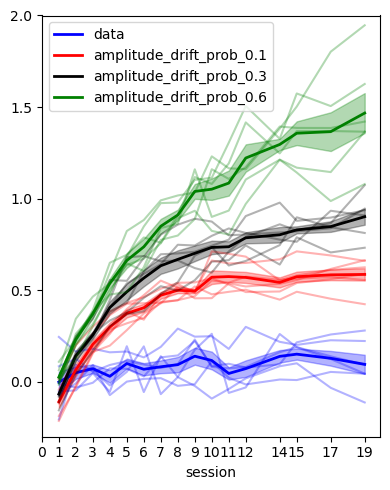

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,time,2.589393,15,75,0.172626,32.673887,8.799999e-27,0.000001,0.661922,0.193923
1,condition,5.318938,1,5,5.318938,93.725417,1.996423e-04,0.000200,0.800867,1.000000
2,time * condition,1.455878,15,75,0.097059,19.430173,5.782401e-20,0.000022,0.523996,0.197968


,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,time,4.336682,15,75,0.289112,47.595760,4.233992e-32,6.240985e-08,0.722854,0.201028
1,condition,12.165925,1,5,12.165925,147.652220,6.671063e-05,6.671063e-05,0.879763,1.000000
2,time * condition,2.767473,15,75,0.184498,39.650822,1.746204e-29,9.345317e-08,0.624686,0.213720


,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,time,9.689828,15,75,0.645989,55.552159,2.344909e-34,1.125517e-08,0.777856,0.209671
1,condition,30.853860,1,5,30.853860,277.347724,1.425968e-05,1.425968e-05,0.917693,1.000000
2,time * condition,7.234645,15,75,0.482310,50.673669,5.204845e-33,8.628115e-07,0.723326,0.159313


In [63]:

print_large('Changing amplitude scale. amplitude_drift_prob=0.3, remap_prob=0.3')
angles_amplitude_change_scale_variation__025 = [data for data in results['amplitude_change_scale_variation']['pop_geometry_angles'][0]]
angles_amplitude_change_scale_variation__05 = [data for data in results['amplitude_change_scale_variation']['pop_geometry_angles'][1]]
angles_amplitude_change_scale_variation__075 = [data for data in results['amplitude_change_scale_variation']['pop_geometry_angles'][2]]

fig, ax = plt.subplots(figsize=(4, 5))
plots.plot_average_geometry([forward_data_pop_geometry_angles, angles_amplitude_change_scale_variation__025, angles_amplitude_change_scale_variation__05, 
                             angles_amplitude_change_scale_variation__075], maps, colors=['b','r', 'k', 'g'], 
                          labels=['data','ampltude_change_scale_0.25', 'ampltude_change_scale_0.5', 'ampltude_change_scale_0.75'], 
                          plot_individual=True, ylim=[-0.3, 2], ax=ax)
plt.show()
print_large('\n TWO-WAY REPEATED ANOVA: ampltude_change_scale_0.25 vs data')
anova=st.repeated_measures_anova_general([np.vstack(angles_amplitude_change_scale_variation__025), np.vstack(forward_data_pop_geometry_angles)])
display(anova[0])

print_large('\n TWO-WAY REPEATED ANOVA: ampltude_change_scale_0.5 vs data')
anova=st.repeated_measures_anova_general([np.vstack(angles_amplitude_change_scale_variation__05), np.vstack(forward_data_pop_geometry_angles)])
display(anova[0])

print_large('\n TWO-WAY REPEATED ANOVA: ampltude_change_scale_0.75 vs data')
anova=st.repeated_measures_anova_general([np.vstack(angles_amplitude_change_scale_variation__075), np.vstack(forward_data_pop_geometry_angles)])
display(anova[0])




print_large('Changing remap probability. amplitude_drift_prob=0.3, amplitude_change_scale=0.5')
angles_max_remap_prob_variation__025 = [data for data in results['max_remap_prob_variation']['pop_geometry_angles'][0]]
angles_max_remap_prob_variation__05 = [data for data in results['max_remap_prob_variation']['pop_geometry_angles'][1]]
angles_max_remap_prob_variation__075 = [data for data in results['max_remap_prob_variation']['pop_geometry_angles'][2]]

fig, ax = plt.subplots(figsize=(4, 5))
plots.plot_average_geometry([forward_data_pop_geometry_angles, angles_max_remap_prob_variation__025, angles_max_remap_prob_variation__05, 
                             angles_max_remap_prob_variation__075], maps, colors=['b','r', 'k', 'g'], 
                          labels=['data','remap_prob_0.1', 'remap_prob_0.3', 'remap_prob_0.6'], 
                          plot_individual=True, ylim=[-0.3, 2], ax=ax)
plt.show()

print_large('\n TWO-WAY REPEATED ANOVA: remap_prob_0.1 vs data')
anova=st.repeated_measures_anova_general([np.vstack(angles_max_remap_prob_variation__025), np.vstack(forward_data_pop_geometry_angles)])
display(anova[0])

print_large('\n TWO-WAY REPEATED ANOVA: remap_prob_0.3 vs data')
anova=st.repeated_measures_anova_general([np.vstack(angles_max_remap_prob_variation__05), np.vstack(forward_data_pop_geometry_angles)])
display(anova[0])

print_large('\n TWO-WAY REPEATED ANOVA: remap_prob_0.6 vs data')
anova=st.repeated_measures_anova_general([np.vstack(angles_max_remap_prob_variation__075), np.vstack(forward_data_pop_geometry_angles)])
display(anova[0])





print_large('Changing amplitude probability. remap_prob=0.3, amplitude_change_scale=0.5')
angles_amplitude_drift_prob_variation__025 = [data for data in results['amplitude_drift_prob_variation']['pop_geometry_angles'][0]]
angles_amplitude_drift_prob_variation__05 = [data for data in results['amplitude_drift_prob_variation']['pop_geometry_angles'][1]]
angles_amplitude_drift_prob_variation__075 = [data for data in results['amplitude_drift_prob_variation']['pop_geometry_angles'][2]]

fig, ax = plt.subplots(figsize=(4, 5))
plots.plot_average_geometry([forward_data_pop_geometry_angles, angles_amplitude_drift_prob_variation__025, angles_amplitude_drift_prob_variation__05, 
                             angles_amplitude_drift_prob_variation__075], maps, colors=['b','r', 'k', 'g'], 
                          labels=['data','amplitude_drift_prob_0.1', 'amplitude_drift_prob_0.3', 'amplitude_drift_prob_0.6'], 
                          plot_individual=True, ylim=[-0.3, 2], ax=ax)
plt.show()

print_large('\n TWO-WAY REPEATED ANOVA: amplitude_drift_prob_0.1 vs data')
anova=st.repeated_measures_anova_general([np.vstack(angles_amplitude_drift_prob_variation__025), np.vstack(forward_data_pop_geometry_angles)])
display(anova[0])

print_large('\n TWO-WAY REPEATED ANOVA: amplitude_drift_prob_0.3 vs data')
anova=st.repeated_measures_anova_general([np.vstack(angles_amplitude_drift_prob_variation__05), np.vstack(forward_data_pop_geometry_angles)])
display(anova[0])

print_large('\n TWO-WAY REPEATED ANOVA: amplitude_drift_prob_0.6 vs data')
anova=st.repeated_measures_anova_general([np.vstack(angles_amplitude_drift_prob_variation__075), np.vstack(forward_data_pop_geometry_angles)])
display(anova[0])


In [8]:
def analyze_data_common(datapath, reference, maps, analysis_type, method='subspace', compute_day11_12=False, 
                        transients=False, dim_red=False, max_dim=4, standardize='stand'):
    def get_analysis_function(analysis_type):
        if analysis_type == 'population_geometry':
            return analysis.populationgeometry, analysis.populationgeometry_context
        elif analysis_type == 'topology':
            return analysis.topology_analysis, analysis.topology_analysis_context


    analysis_func, context_func = get_analysis_function(analysis_type)

    def apply_analysis(func, *args):
        if analysis_type == 'population_geometry':
            return func(*args, method=method)
        else:
            return func(*args, max_dim=max_dim)

    stable=analysis.neuron_stability(datapath, 'Context1', [reference] + maps, transients=transients, dim_red=dim_red, standardize=standardize, remove_day_inactive=False)
    hists = analysis.sort_maps_from_reference_AK(datapath, 'Context1', reference=reference, maps=maps, 
                                                 reference_type='no_reference', hist='hist', transients=transients, dim_red=dim_red, 
                                                 standardize=standardize, remove_day_inactive=False, remove_stable=stable, remove_stable_tresh=0.7)
    #hists=hists[::-1] 
    g = apply_analysis(analysis_func, hists)

    global_seeds = [1,2,3,4,5]
    simu_g_list = []
    for seed in global_seeds:
        simu_drift = analysis.simulate_drift(datapath, session='0', Context='Context1', days=len(maps)+1, 
                                             drift_type='circular', dim_red=dim_red, standardize=standardize, odd_even=True, 
                                             global_seed=seed, active_days=[reference]+maps, remove_day_inactive=True, 
                                             max_remap_prob=0.3, amplitude_drift_prob=0.3, amplitude_change_scale=0.5)
        simu_g = apply_analysis(analysis_func, simu_drift['maps'])
        simu_g_list.append(simu_g)
    simu_g_array = np.array(simu_g_list)
    simu_g = np.mean(simu_g_array, axis=0)

    hist_odd, hist_even = analysis.sort_maps_from_reference_within_session_AK(datapath, 'Context1', maps=maps, 
                                                                                  transients=transients, dim_red=dim_red,
                                                                                    standardize=standardize, remove_day_inactive=False)
    g_odd_even1 = apply_analysis(context_func, hist_odd, hist_even)

    if analysis_type == 'population_geometry':      

        shuff1, shuff2 = analysis.shuffle_two_sessions_hist(datapath, '0', '19', 'Context1', dim_red=dim_red, remove_inactive=[reference]+maps, 
                                                            standardize=standardize, remove_day_inactive=False)
        g_shuff1 = apply_analysis(context_func, [shuff1], [shuff2])

        
        g = (g - np.mean(g_odd_even1)) / (np.mean(g_shuff1) - np.mean(g_odd_even1))
        simu_g = (simu_g - np.mean(g_odd_even1)) / (np.mean(g_shuff1) - np.mean(g_odd_even1))
    else:
        g = g-g_odd_even1
  
    return g, simu_g


def collect_data(datapaths, reference, maps, analysis_type, method='subspace', compute_day11_12=False, transients=False, dim_red=False, max_dim=3, standardize='stand'):
    all_data = []
    for datapath in datapaths:
        data = analyze_data_common(datapath, reference, maps, analysis_type, method=method, compute_day11_12=compute_day11_12, transients=transients, dim_red=dim_red, max_dim=max_dim, standardize=standardize)
        all_data.append(data)
    return all_data

if __name__ == "__main__":
    datapaths = ['D:/Antje_CA1/data_sig/170.h5', 'D:/Antje_CA1/data_sig/51004.h5', 'D:/Antje_CA1/data_sig/51007.h5', 'D:/Antje_CA1/data_sig/63.h5', 'D:/Antje_CA1/data_sig/64.h5', 'D:/Antje_CA1/data_sig/65.h5']
    transients = False
    dim_red = False
    max_dim = 4

    reference = '0'
    maps = [str(i) for i in np.arange(1, 13)] +  ['14', '15', '17', '19']
    forward_data_pop_geometry_subspace = collect_data(datapaths, reference, maps, 'population_geometry', method='subspace', compute_day11_12=False, transients=transients, dim_red=dim_red, standardize='stand')
    forward_data_pop_geometry_angles = collect_data(datapaths, reference, maps, 'population_geometry', method='angles', compute_day11_12=False, transients=transients, dim_red=dim_red, standardize='stand')
    forward_data_topology = collect_data(datapaths, reference, maps, 'topology', compute_day11_12=False, transients=transients, dim_red=dim_red, max_dim=max_dim, standardize='stand')



c:\Users\Ole\anaconda3\envs\spyder-env\lib\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
c:\Users\Ole\Documents\script\remapping\remapping\analysis.py:475: RuntimeWarning: Mean of empty slice
  raise ValueError("Need at least 2 days of data to compute correlations")
c:\Users\Ole\anaconda3\envs\spyder-env\lib\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
c:\Users\Ole\Documents\script\remapping\remapping\analysis.py:475: RuntimeWarning: Mean of empty slice
  raise ValueError("Need at least 2 days of data to compute correlations")
c:\Users\Ole\anaconda3\envs\spyder-env\lib\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.


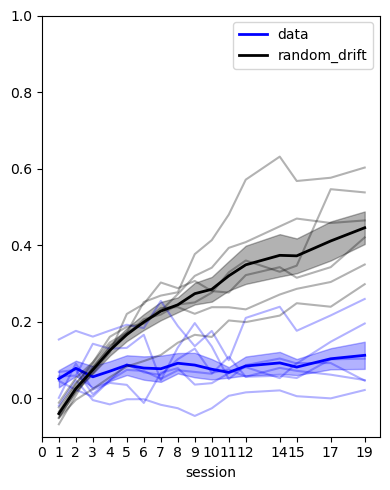

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,time,1.062446,15,75,0.070830,29.353490,2.548698e-25,0.000096,0.503811,0.126553
1,condition,1.224205,1,5,1.224205,21.948475,5.409665e-03,0.005410,0.539160,1.000000
2,time * condition,0.761377,15,75,0.050758,21.817537,2.020523e-21,0.000046,0.421173,0.167224


,Timepoint,Condition 1,Condition 2,Test Used,Statistic,p-value,Adjusted p-value (bonferroni),Significance,Effect Size,Effect Size Type,Mean Cond 1,Mean Cond 2,Mean Diff,SD Diff,N,Normal Dist.,Normality p-value
0,T1,C1,C2,t-test,4.2649,0.0080,0.1276,,1.7411,Cohen's d,0.0515,-0.0398,0.0913,0.0524,6,True,0.1820
1,T2,C1,C2,wilcoxon,0.0000,0.0312,0.5000,,0.8987,r,0.0786,0.0256,0.0530,0.0486,6,False,0.0208
2,T3,C1,C2,t-test,-0.6802,0.5266,1.0000,,-0.2777,Cohen's d,0.0565,0.0747,-0.0182,0.0657,6,True,0.1960
3,T4,C1,C2,t-test,-2.1556,0.0837,1.0000,,-0.8800,Cohen's d,0.0711,0.1254,-0.0543,0.0617,6,True,0.3297
4,T5,C1,C2,t-test,-2.2414,0.0751,1.0000,,-0.9150,Cohen's d,0.0869,0.1668,-0.0799,0.0873,6,True,0.4809
5,T6,C1,C2,t-test,-2.5963,0.0485,0.7754,,-1.0599,Cohen's d,0.0794,0.1994,-0.1201,0.1133,6,True,0.1342
6,T7,C1,C2,t-test,-3.0942,0.0270,0.4325,,-1.2632,Cohen's d,0.0775,0.2281,-0.1506,0.1192,6,True,0.8305
7,T8,C1,C2,t-test,-4.1177,0.0092,0.1471,,-1.6811,Cohen's d,0.0919,0.2444,-0.1525,0.0907,6,True,0.2426
8,T9,C1,C2,t-test,-3.4818,0.0176,0.2820,,-1.4214,Cohen's d,0.0871,0.2736,-0.1865,0.1312,6,True,0.1439
9,T10,C1,C2,t-test,-4.7805,0.0050,0.0795,,-1.9516,Cohen's d,0.0762,0.2850,-0.2088,0.1070,6,True,0.3047


,Source,SS,DF,MS,F,p-unc,ng2,eps
0,time,0.021819,15,0.001455,1.292604,0.228354,0.049436,0.213647
1,Error,0.084399,75,0.001125,NaN,NaN,NaN,NaN


,Source,SS,DF,MS,F,p-unc,ng2,eps
0,time,1.802004,15,0.120134,33.239635,5.104150e-27,0.741919,0.104799
1,Error,0.271062,75,0.003614,NaN,NaN,NaN,NaN


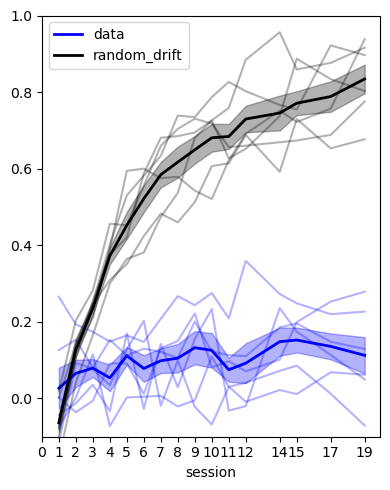

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,time,3.719369,15,75,0.247958,43.238533,1.020929e-30,1.228505e-07,0.714009,0.200591
1,condition,9.549400,1,5,9.549400,164.166388,5.154171e-05,5.154171e-05,0.865047,1.000000
2,time * condition,2.412361,15,75,0.160824,37.149429,1.446897e-28,1.342217e-07,0.618217,0.215254


,Timepoint,Condition 1,Condition 2,Test Used,Statistic,p-value,Adjusted p-value (bonferroni),Significance,Effect Size,Effect Size Type,Mean Cond 1,Mean Cond 2,Mean Diff,SD Diff,N,Normal Dist.,Normality p-value
0,T1,C1,C2,t-test,2.2174,0.0774,1.0000,,0.9053,Cohen's d,0.0269,-0.0637,0.0906,0.1000,6,True,0.4494
1,T2,C1,C2,t-test,-1.9485,0.1089,1.0000,,-0.7955,Cohen's d,0.0654,0.1281,-0.0627,0.0788,6,True,0.8739
2,T3,C1,C2,t-test,-6.1894,0.0016,0.0257,*,-2.5268,Cohen's d,0.0793,0.2347,-0.1554,0.0615,6,True,0.5547
3,T4,C1,C2,t-test,-9.6132,0.0002,0.0033,**,-3.9246,Cohen's d,0.0537,0.3722,-0.3185,0.0812,6,True,0.9311
4,T5,C1,C2,t-test,-8.3199,0.0004,0.0066,**,-3.3966,Cohen's d,0.1114,0.4521,-0.3406,0.1003,6,True,0.9227
5,T6,C1,C2,wilcoxon,0.0000,0.0312,0.5000,,0.8987,r,0.0782,0.5216,-0.4434,0.0698,6,False,0.0033
6,T7,C1,C2,t-test,-8.6315,0.0003,0.0055,**,-3.5238,Cohen's d,0.0985,0.5843,-0.4858,0.1379,6,True,0.6011
7,T8,C1,C2,t-test,-9.4103,0.0002,0.0037,**,-3.8417,Cohen's d,0.1051,0.6172,-0.5121,0.1333,6,True,0.8710
8,T9,C1,C2,t-test,-9.5673,0.0002,0.0034,**,-3.9058,Cohen's d,0.1325,0.6492,-0.5167,0.1323,6,True,0.5014
9,T10,C1,C2,t-test,-26.4158,1.4532e-06,2.3252e-05,***,-10.7842,Cohen's d,0.1256,0.6807,-0.5551,0.0515,6,True,0.3499


,Source,SS,DF,MS,F,p-unc,ng2,eps
0,time,0.112112,15,0.007474,1.486355,0.132251,0.117055,0.22681
1,Error,0.377137,75,0.005028,NaN,NaN,NaN,NaN


,Source,SS,DF,MS,F,p-unc,ng2,eps
0,time,6.019618,15,0.401308,79.699261,9.419049e-40,0.903341,0.240053
1,Error,0.377646,75,0.005035,NaN,NaN,NaN,NaN


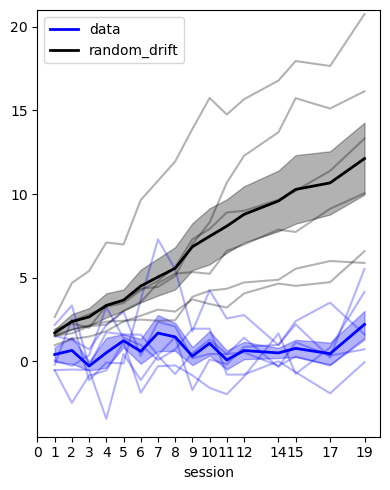

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,time,554.116503,15,75,36.94110,14.923691,8.309732e-17,0.002049,0.287570,0.113629
1,condition,1529.617990,1,5,1529.61799,21.144618,5.849195e-03,0.005849,0.527020,1.000000
2,time * condition,448.231951,15,75,29.88213,8.822171,2.756713e-11,0.004498,0.246145,0.146868


,Timepoint,Condition 1,Condition 2,Test Used,Statistic,p-value,Adjusted p-value (bonferroni),Significance,Effect Size,Effect Size Type,Mean Cond 1,Mean Cond 2,Mean Diff,SD Diff,N,Normal Dist.,Normality p-value
0,T1,C1,C2,t-test,-3.1318,0.0259,0.4145,,-1.2786,Cohen's d,0.4119,1.7088,-1.2969,1.0143,6,True,0.0872
1,T2,C1,C2,t-test,-1.9896,0.1033,1.0000,,-0.8123,Cohen's d,0.6586,2.3814,-1.7228,2.1211,6,True,0.3492
2,T3,C1,C2,t-test,-6.9553,0.0009,0.0151,*,-2.8395,Cohen's d,-0.2742,2.6603,-2.9345,1.0335,6,True,0.6828
3,T4,C1,C2,t-test,-2.4552,0.0576,0.9210,,-1.0023,Cohen's d,0.5194,3.3476,-2.8283,2.8217,6,True,0.9907
4,T5,C1,C2,t-test,-4.3345,0.0075,0.1195,,-1.7696,Cohen's d,1.2386,3.6610,-2.4223,1.3689,6,True,0.3478
5,T6,C1,C2,t-test,-2.9302,0.0326,0.5220,,-1.1963,Cohen's d,0.6012,4.5039,-3.9027,3.2625,6,True,0.5037
6,T7,C1,C2,t-test,-2.2145,0.0777,1.0000,,-0.9041,Cohen's d,1.6938,5.0435,-3.3497,3.7051,6,True,0.7079
7,T8,C1,C2,t-test,-2.6977,0.0429,0.6864,,-1.1013,Cohen's d,1.4634,5.5638,-4.1004,3.7231,6,True,0.9383
8,T9,C1,C2,wilcoxon,0.0000,0.0312,0.5000,,0.8987,r,0.3148,6.8523,-6.5375,3.6914,6,False,0.0416
9,T10,C1,C2,wilcoxon,0.0000,0.0312,0.5000,,0.8987,r,1.0816,7.4761,-6.3945,4.5054,6,False,0.0088


,Source,SS,DF,MS,F,p-unc,ng2,eps
0,time,35.409892,15,2.360659,1.002915,0.461547,0.121654,0.215777
1,Error,176.534778,75,2.353797,NaN,NaN,NaN,NaN


,Source,SS,DF,MS,F,p-unc,ng2,eps
0,time,966.938561,15,64.462571,18.372217,2.825856e-19,0.463971,0.087542
1,Error,263.152383,75,3.508698,NaN,NaN,NaN,NaN


In [10]:
print_large('REMOVING STABLE NEURONS')
# Subspace geometry analysis
print_large('\n' + '='*50)
print_large('RM ANOVA: SUBSPACE angles')
print_large('='*50)
fig, ax = plt.subplots(figsize=(4, 5))
g = [data[0] for data in forward_data_pop_geometry_subspace]
simu_g = [data[1] for data in forward_data_pop_geometry_subspace]
plots.plot_average_geometry([g, simu_g], maps, colors=['b', 'k'], 
                          labels=['data', 'random_drift'], 
                          plot_individual=True, ylim=[-0.1, 1], ax=ax)
plt.show()  

print_large('\nTWO-WAY REPEATED ANOVA')
anova=st.repeated_measures_anova_general([np.vstack(g), np.vstack(simu_g)])
display(anova[0])
display(anova[1])
print_large('\nData: ONE-WAY RM ANOVA')
display(st.repeated_measures_anova_single_condition(np.vstack(g)))
print_large('\nRandom Drift: oNE-WAY RM ANOVA')
display(st.repeated_measures_anova_single_condition(np.vstack(simu_g)))

# Angles analysis
print_large('\n' + '='*50)
print_large('RM ANOVA: Edge angles')
print_large('='*50)
fig, ax = plt.subplots(figsize=(4, 5))
g = [data[0] for data in forward_data_pop_geometry_angles]
simu_g = [data[1] for data in forward_data_pop_geometry_angles]
plots.plot_average_geometry([g, simu_g], maps, colors=['b', 'k'], 
                          labels=['data', 'random_drift'], 
                          plot_individual=True, ylim=[-0.1, 1], ax=ax)
plt.show()  

print_large('\nTWO-WAY REPEATED ANOVA')
anova=st.repeated_measures_anova_general([np.vstack(g), np.vstack(simu_g)])
display(anova[0])
display(anova[1])
print_large('\nData:')
display(st.repeated_measures_anova_single_condition(np.vstack(g)))
print_large('\nRandom Drift:')
display(st.repeated_measures_anova_single_condition(np.vstack(simu_g)))

# Topology analysis
print_large('\n' + '='*50)
print_large('RM ANOVA: Persistent homology')
print_large('='*50)
fig, ax = plt.subplots(figsize=(4, 5))
g = [data[0] for data in forward_data_topology]
simu_g = [data[1] for data in forward_data_topology]
plots.plot_average_geometry([g, simu_g], maps, colors=['b', 'k'], 
                          labels=['data', 'random_drift'], 
                          plot_individual=True, ylim=[-4.5, 21], ax=ax)
plt.show()  

print_large('\nTWO-WAY REPEATED ANOVA')
anova=st.repeated_measures_anova_general([np.vstack(g), np.vstack(simu_g)])
display(anova[0])
display(anova[1])
print_large('\nData:')
display(st.repeated_measures_anova_single_condition(np.vstack(g)))
print_large('\nRandom Drift:')
display(st.repeated_measures_anova_single_condition(np.vstack(simu_g)))

In [47]:
def analyze_data_common(datapath, reference, maps, analysis_type, method='subspace', compute_day11_12=False, 
                        transients=False, dim_red=False, max_dim=4, standardize='stand'):
    def get_analysis_function(analysis_type):
        if analysis_type == 'population_geometry':
            return analysis.populationgeometry, analysis.populationgeometry_context
        elif analysis_type == 'topology':
            return analysis.topology_analysis, analysis.topology_analysis_context


    analysis_func, context_func = get_analysis_function(analysis_type)

    def apply_analysis(func, *args):
        if analysis_type == 'population_geometry':
            return func(*args, method=method)
        else:
            return func(*args, max_dim=max_dim)

    hists = analysis.sort_maps_from_reference_AK(datapath, 'Context1', reference=reference, maps=maps, reference_type='no_reference',
                                                  hist='hist', transients=transients, dim_red=dim_red, 
                                                  standardize=standardize, remove_day_inactive=False)
    #hists=hists[::-1] 
    g = apply_analysis(analysis_func, hists)

    global_seeds = [1,2,3,4,5]
    simu_g_list = []
    for seed in global_seeds:
        simu_drift = analysis.simulate_drift(datapath, session='0', Context='Context1', days=len(maps)+1, 
                                             drift_type='circular', dim_red=dim_red, standardize=standardize, odd_even=True, 
                                             global_seed=seed, active_days=[reference]+maps, remove_day_inactive=True, 
                                             max_remap_prob=0.3, amplitude_drift_prob=0.3, amplitude_change_scale=0.5)
        simu_g = apply_analysis(analysis_func, simu_drift['maps'])
        simu_g_list.append(simu_g)
    simu_g_array = np.array(simu_g_list)
    simu_g = np.mean(simu_g_array, axis=0)

    hist_odd, hist_even = analysis.sort_maps_from_reference_within_session_AK(datapath, 'Context1', maps=maps, 
                                                                                  transients=transients, dim_red=dim_red,
                                                                                    standardize=standardize, remove_day_inactive=False)
    g_odd_even1 = apply_analysis(context_func, hist_odd, hist_even)

    if analysis_type == 'population_geometry':      

        shuff1, shuff2 = analysis.shuffle_two_sessions_hist(datapath, '0', '19', 'Context1', dim_red=dim_red, remove_inactive=[reference]+maps, 
                                                            standardize=standardize, remove_day_inactive=False)
        g_shuff1 = apply_analysis(context_func, [shuff1], [shuff2])

        
        g = (g - np.mean(g_odd_even1)) / (np.mean(g_shuff1) - np.mean(g_odd_even1))
        simu_g = (simu_g - np.mean(g_odd_even1)) / (np.mean(g_shuff1) - np.mean(g_odd_even1))
    else:
        g = g-g_odd_even1
    return g, simu_g


def collect_data(datapaths, reference, maps, analysis_type, method='subspace', compute_day11_12=False, transients=False, dim_red=False, max_dim=3, standardize='stand'):
    all_data = []
    for datapath in datapaths:
        data = analyze_data_common(datapath, reference, maps, analysis_type, method=method, compute_day11_12=compute_day11_12, transients=transients, dim_red=dim_red, max_dim=max_dim, standardize=standardize)
        all_data.append(data)
    return all_data

if __name__ == "__main__":
    datapaths = ['D:/Antje_CA1/data_sig/170.h5', 'D:/Antje_CA1/data_sig/51004.h5', 'D:/Antje_CA1/data_sig/51007.h5', 'D:/Antje_CA1/data_sig/63.h5', 'D:/Antje_CA1/data_sig/64.h5', 'D:/Antje_CA1/data_sig/65.h5']
    transients = False
    dim_red = 'pca'
    max_dim = 4

    reference = '0'
    maps = [str(i) for i in np.arange(1, 13)] +  ['14', '15', '17', '19']
    forward_data_pop_geometry_subspace = collect_data(datapaths, reference, maps, 'population_geometry', method='subspace', compute_day11_12=False, transients=transients, dim_red=dim_red, standardize='stand')
    forward_data_pop_geometry_angles = collect_data(datapaths, reference, maps, 'population_geometry', method='angles', compute_day11_12=False, transients=transients, dim_red=dim_red, standardize='stand')
    forward_data_topology = collect_data(datapaths, reference, maps, 'topology', compute_day11_12=False, transients=transients, dim_red=dim_red, max_dim=max_dim, standardize='stand')


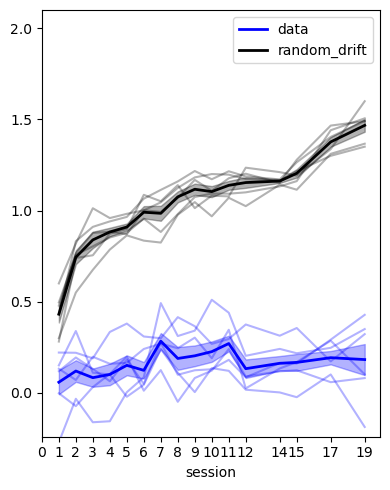

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,time,3.726267,15,75,0.248418,27.034492,3.240590e-24,0.000008,0.618903,0.178325
1,condition,36.378458,1,5,36.378458,610.236928,2.027508e-06,0.000002,0.940669,1.000000
2,time * condition,2.126211,15,75,0.141747,14.081395,3.824190e-16,0.000201,0.480967,0.185828


,Timepoint,Condition 1,Condition 2,Test Used,Statistic,p-value,Adjusted p-value (bonferroni),Significance,Effect Size,Effect Size Type,Mean Cond 1,Mean Cond 2,Mean Diff,SD Diff,N,Normal Dist.,Normality p-value
0,T1,C1,C2,t-test,-5.9441,0.0019,0.0308,*,-2.4267,Cohen's d,0.0589,0.4319,-0.3731,0.1537,6,True,0.8823
1,T2,C1,C2,t-test,-10.8151,0.0001,0.0019,**,-4.4153,Cohen's d,0.1202,0.7443,-0.6241,0.1413,6,True,0.8804
2,T3,C1,C2,t-test,-23.8740,2.4019e-06,3.8430e-05,***,-9.7465,Cohen's d,0.0838,0.8392,-0.7554,0.0775,6,True,0.3556
3,T4,C1,C2,t-test,-16.9634,1.3023e-05,0.0002,***,-6.9253,Cohen's d,0.1015,0.8827,-0.7812,0.1128,6,True,0.8951
4,T5,C1,C2,t-test,-15.6194,1.9548e-05,0.0003,***,-6.3766,Cohen's d,0.1516,0.9100,-0.7584,0.1189,6,True,0.9132
5,T6,C1,C2,t-test,-14.0426,3.2942e-05,0.0005,***,-5.7329,Cohen's d,0.1240,0.9910,-0.8670,0.1512,6,True,0.2337
6,T7,C1,C2,wilcoxon,0.0000,0.0312,0.5000,,0.8987,r,0.2841,0.9851,-0.7010,0.1858,6,False,0.0089
7,T8,C1,C2,t-test,-12.3188,6.2413e-05,0.0010,***,-5.0291,Cohen's d,0.1892,1.0752,-0.8861,0.1762,6,True,0.1413
8,T9,C1,C2,t-test,-15.6025,1.9652e-05,0.0003,***,-6.3697,Cohen's d,0.2037,1.1170,-0.9133,0.1434,6,True,0.8444
9,T10,C1,C2,wilcoxon,0.0000,0.0312,0.5000,,0.8987,r,0.2265,1.1041,-0.8776,0.2103,6,False,0.0054


,Source,SS,DF,MS,F,p-unc,ng2,eps
0,time,0.355139,15,0.023676,1.522153,0.118966,0.171135,0.173959
1,Error,1.166568,75,0.015554,NaN,NaN,NaN,NaN


,Source,SS,DF,MS,F,p-unc,ng2,eps
0,time,5.497338,15,0.366489,99.025298,4.556061e-43,0.905393,0.183864
1,Error,0.277572,75,0.003701,NaN,NaN,NaN,NaN


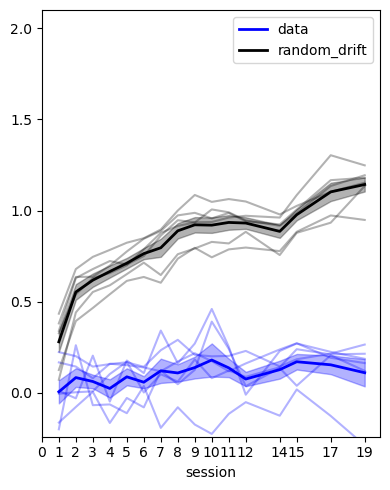

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,time,2.970720,15,75,0.198048,31.838041,1.996918e-26,0.000038,0.525344,0.136696
1,condition,24.551351,1,5,24.551351,679.217864,1.554013e-06,0.000002,0.901449,1.000000
2,time * condition,1.490025,15,75,0.099335,15.127725,5.792702e-17,0.000487,0.356968,0.151389


,Timepoint,Condition 1,Condition 2,Test Used,Statistic,p-value,Adjusted p-value (bonferroni),Significance,Effect Size,Effect Size Type,Mean Cond 1,Mean Cond 2,Mean Diff,SD Diff,N,Normal Dist.,Normality p-value
0,T1,C1,C2,t-test,-10.5475,0.0001,0.0021,**,-4.3060,Cohen's d,0.0061,0.2803,-0.2742,0.0637,6,True,0.1544
1,T2,C1,C2,t-test,-7.1278,0.0008,0.0135,*,-2.9099,Cohen's d,0.0843,0.5536,-0.4693,0.1613,6,True,0.3920
2,T3,C1,C2,t-test,-15.1922,2.2400e-05,0.0004,***,-6.2022,Cohen's d,0.0629,0.6186,-0.5557,0.0896,6,True,0.1501
3,T4,C1,C2,t-test,-17.7444,1.0431e-05,0.0002,***,-7.2441,Cohen's d,0.0247,0.6659,-0.6413,0.0885,6,True,0.7766
4,T5,C1,C2,t-test,-16.9555,1.3053e-05,0.0002,***,-6.9220,Cohen's d,0.0885,0.7117,-0.6232,0.0900,6,True,0.6278
5,T6,C1,C2,t-test,-36.1438,3.0520e-07,4.8832e-06,***,-14.7556,Cohen's d,0.0590,0.7640,-0.7050,0.0478,6,True,0.6892
6,T7,C1,C2,t-test,-11.1939,9.9305e-05,0.0016,**,-4.5699,Cohen's d,0.1214,0.7961,-0.6747,0.1476,6,True,0.3406
7,T8,C1,C2,t-test,-24.9763,1.9197e-06,3.0715e-05,***,-10.1965,Cohen's d,0.1097,0.8891,-0.7794,0.0764,6,True,0.1249
8,T9,C1,C2,t-test,-16.3853,1.5447e-05,0.0002,***,-6.6893,Cohen's d,0.1391,0.9220,-0.7829,0.1170,6,True,0.5324
9,T10,C1,C2,t-test,-6.6645,0.0011,0.0184,*,-2.7208,Cohen's d,0.1807,0.9202,-0.7395,0.2718,6,True,0.5845


,Source,SS,DF,MS,F,p-unc,ng2,eps
0,time,0.223297,15,0.014886,1.379472,0.179837,0.112491,0.128953
1,Error,0.809356,75,0.010791,NaN,NaN,NaN,NaN


,Source,SS,DF,MS,F,p-unc,ng2,eps
0,time,4.237448,15,0.282497,141.567008,1.302854e-48,0.82124,0.21425
1,Error,0.149662,75,0.001995,NaN,NaN,NaN,NaN


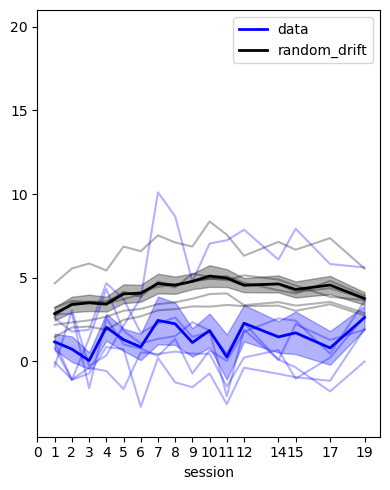

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,time,53.061292,15,75,3.537419,2.162640,0.015230,0.162752,0.071257,0.139283
1,condition,366.334097,1,5,366.334097,11.689822,0.018858,0.018858,0.346277,1.000000
2,time * condition,39.557309,15,75,2.637154,1.686441,0.072040,0.238523,0.054103,0.118204


,Timepoint,Condition 1,Condition 2,Test Used,Statistic,p-value,Adjusted p-value (bonferroni),Significance,Effect Size,Effect Size Type,Mean Cond 1,Mean Cond 2,Mean Diff,SD Diff,N,Normal Dist.,Normality p-value
0,T1,C1,C2,t-test,-2.9195,0.0330,0.5285,,-1.1919,Cohen's d,1.1687,2.8520,-1.6833,1.4123,6,True,0.5191
1,T2,C1,C2,t-test,-2.9194,0.0330,0.5286,,-1.1918,Cohen's d,0.7347,3.4003,-2.6656,2.2366,6,True,0.1693
2,T3,C1,C2,wilcoxon,0.0000,0.0312,0.5000,,0.8987,r,0.0517,3.5019,-3.4502,0.7724,6,False,0.0479
3,T4,C1,C2,t-test,-1.8517,0.1233,1.0000,,-0.7559,Cohen's d,2.0390,3.4212,-1.3822,1.8284,6,True,0.5512
4,T5,C1,C2,wilcoxon,0.0000,0.0312,0.5000,,0.8987,r,1.2973,4.0407,-2.7433,1.3711,6,False,0.0188
5,T6,C1,C2,t-test,-4.1188,0.0092,0.1470,,-1.6815,Cohen's d,0.8605,4.0719,-3.2114,1.9099,6,True,0.7552
6,T7,C1,C2,wilcoxon,6.0000,0.4375,1.0000,,0.3852,r,2.4491,4.6513,-2.2022,3.8083,6,False,0.0094
7,T8,C1,C2,wilcoxon,4.0000,0.2188,1.0000,,0.5563,r,2.2482,4.5553,-2.3072,3.2677,6,False,0.0106
8,T9,C1,C2,t-test,-4.3670,0.0072,0.1159,,-1.7828,Cohen's d,1.1297,4.7847,-3.6551,2.0502,6,True,0.0930
9,T10,C1,C2,t-test,-2.7460,0.0405,0.6480,,-1.1211,Cohen's d,1.8453,5.1021,-3.2568,2.9051,6,True,0.2301


,Source,SS,DF,MS,F,p-unc,ng2,eps
0,time,54.604394,15,3.640293,1.166115,0.316633,0.090843,0.124422
1,Error,234.129625,75,3.121728,NaN,NaN,NaN,NaN


,Source,SS,DF,MS,F,p-unc,ng2,eps
0,time,38.014207,15,2.534280,32.61393,9.327268e-27,0.207588,0.14962
1,Error,5.827910,75,0.077705,NaN,NaN,NaN,NaN


In [48]:
print_large('PCA')
# Subspace geometry analysis
print_large('\n' + '='*50)
print_large('RM ANOVA: SUBSPACE angles')
print_large('='*50)
fig, ax = plt.subplots(figsize=(4, 5))
g = [data[0] for data in forward_data_pop_geometry_subspace]
simu_g = [data[1] for data in forward_data_pop_geometry_subspace]
plots.plot_average_geometry([g, simu_g], maps, colors=['b', 'k'], 
                          labels=['data', 'random_drift'], 
                          plot_individual=True, ylim=[-0.24, 2.1], ax=ax)
plt.show()  

print_large('\nTWO-WAY REPEATED ANOVA')
anova=st.repeated_measures_anova_general([np.vstack(g), np.vstack(simu_g)])
display(anova[0])
display(anova[1])
print_large('\nData: ONE-WAY RM ANOVA')
display(st.repeated_measures_anova_single_condition(np.vstack(g)))
print_large('\nRandom Drift: oNE-WAY RM ANOVA')
display(st.repeated_measures_anova_single_condition(np.vstack(simu_g)))

# Angles analysis
print_large('\n' + '='*50)
print_large('RM ANOVA: Edge angles')
print_large('='*50)
fig, ax = plt.subplots(figsize=(4, 5))
g = [data[0] for data in forward_data_pop_geometry_angles]
simu_g = [data[1] for data in forward_data_pop_geometry_angles]
plots.plot_average_geometry([g, simu_g], maps, colors=['b', 'k'], 
                          labels=['data', 'random_drift'], 
                          plot_individual=True, ylim=[-0.24, 2.1], ax=ax)
plt.show()  

print_large('\nTWO-WAY REPEATED ANOVA')
anova=st.repeated_measures_anova_general([np.vstack(g), np.vstack(simu_g)])
display(anova[0])
display(anova[1])
print_large('\nData:')
display(st.repeated_measures_anova_single_condition(np.vstack(g)))
print_large('\nRandom Drift:')
display(st.repeated_measures_anova_single_condition(np.vstack(simu_g)))

# Topology analysis
print_large('\n' + '='*50)
print_large('RM ANOVA: Persistent homology')
print_large('='*50)
fig, ax = plt.subplots(figsize=(4, 5))
g = [data[0] for data in forward_data_topology]
simu_g = [data[1] for data in forward_data_topology]
plots.plot_average_geometry([g, simu_g], maps, colors=['b', 'k'], 
                          labels=['data', 'random_drift'], 
                          plot_individual=True, ylim=[-4.5, 21], ax=ax)
plt.show()  

print_large('\nTWO-WAY REPEATED ANOVA')
anova=st.repeated_measures_anova_general([np.vstack(g), np.vstack(simu_g)])
display(anova[0])
display(anova[1])
print_large('\nData:')
display(st.repeated_measures_anova_single_condition(np.vstack(g)))
print_large('\nRandom Drift:')
display(st.repeated_measures_anova_single_condition(np.vstack(simu_g)))

In [40]:
def analyze_data_common(datapath, reference, maps, analysis_type, method='subspace', compute_day11_12=False, 
                        transients=False, dim_red=False, max_dim=4, standardize='stand'):
    def get_analysis_function(analysis_type):
        if analysis_type == 'population_geometry':
            return analysis.populationgeometry, analysis.populationgeometry_context
        elif analysis_type == 'topology':
            return analysis.topology_analysis, analysis.topology_analysis_context


    analysis_func, context_func = get_analysis_function(analysis_type)

    def apply_analysis(func, *args):
        if analysis_type == 'population_geometry':
            return func(*args, method=method)
        else:
            return func(*args, max_dim=max_dim)

    hists = analysis.sort_maps_from_reference_AK(datapath, 'Context1', reference=reference, maps=maps, reference_type='no_reference',
                                                  hist='hist', transients=transients, dim_red=dim_red, 
                                                  standardize=standardize, remove_day_inactive=False)
    #hists=hists[::-1] 
    g = apply_analysis(analysis_func, hists)

    global_seeds = [1,2,3,4,5]
    simu_g_list = []
    for seed in global_seeds:
        simu_drift = analysis.simulate_drift(datapath, session='0', Context='Context1', days=len(maps)+1, 
                                             drift_type='circular', dim_red=dim_red, standardize=standardize, odd_even=True, 
                                             global_seed=seed, active_days=[reference]+maps, remove_day_inactive=True, 
                                             max_remap_prob=0.3, amplitude_drift_prob=0.3, amplitude_change_scale=0.5)
        simu_g = apply_analysis(analysis_func, simu_drift['maps'])
        simu_g_list.append(simu_g)
    simu_g_array = np.array(simu_g_list)
    simu_g = np.mean(simu_g_array, axis=0)

    hist_odd, hist_even = analysis.sort_maps_from_reference_within_session_AK(datapath, 'Context1', maps=maps, 
                                                                                  transients=transients, dim_red=dim_red,
                                                                                    standardize=standardize, remove_day_inactive=False)
    g_odd_even1 = apply_analysis(context_func, hist_odd, hist_even)

    if analysis_type == 'population_geometry':      

        shuff1, shuff2 = analysis.shuffle_two_sessions_hist(datapath, '0', '19', 'Context1', dim_red=dim_red, remove_inactive=[reference]+maps, 
                                                            standardize=standardize, remove_day_inactive=False)
        g_shuff1 = apply_analysis(context_func, [shuff1], [shuff2])

        
        g = (g - np.mean(g_odd_even1)) / (np.mean(g_shuff1) - np.mean(g_odd_even1))
        simu_g = (simu_g - np.mean(g_odd_even1)) / (np.mean(g_shuff1) - np.mean(g_odd_even1))
    else:
        g = g-g_odd_even1
    return g, simu_g


def collect_data(datapaths, reference, maps, analysis_type, method='subspace', compute_day11_12=False, transients=False, dim_red=False, max_dim=3, standardize='stand'):
    all_data = []
    for datapath in datapaths:
        data = analyze_data_common(datapath, reference, maps, analysis_type, method=method, compute_day11_12=compute_day11_12, transients=transients, dim_red=dim_red, max_dim=max_dim, standardize=standardize)
        all_data.append(data)
    return all_data

if __name__ == "__main__":
    datapaths = ['D:/Antje_CA1/data_sig/170.h5', 'D:/Antje_CA1/data_sig/51004.h5', 'D:/Antje_CA1/data_sig/51007.h5', 'D:/Antje_CA1/data_sig/63.h5', 'D:/Antje_CA1/data_sig/64.h5', 'D:/Antje_CA1/data_sig/65.h5']
    transients = False
    dim_red = 'dpca'
    max_dim = 4

    reference = '0'
    maps = [str(i) for i in np.arange(1, 13)] +  ['14', '15', '17', '19']
    forward_data_pop_geometry_subspace = collect_data(datapaths, reference, maps, 'population_geometry', method='subspace', compute_day11_12=False, transients=transients, dim_red=dim_red, standardize='stand')
    forward_data_pop_geometry_angles = collect_data(datapaths, reference, maps, 'population_geometry', method='angles', compute_day11_12=False, transients=transients, dim_red=dim_red, standardize='stand')
    forward_data_topology = collect_data(datapaths, reference, maps, 'topology', compute_day11_12=False, transients=transients, dim_red=dim_red, max_dim=max_dim, standardize='stand')


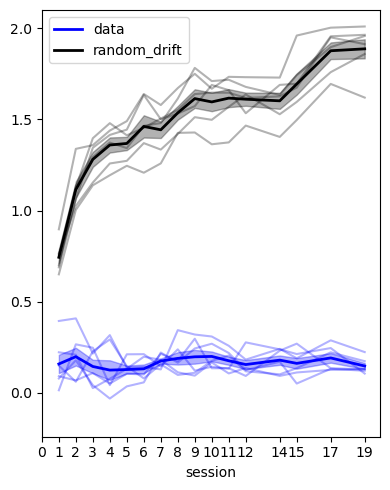

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,time,3.740460,15,75,0.249364,64.924120,1.146472e-36,1.469969e-11,0.669853,0.277724
1,condition,83.785907,1,5,83.785907,819.799640,9.735882e-07,9.735882e-07,0.978471,1.000000
2,time * condition,3.498796,15,75,0.233253,43.923312,6.079406e-31,4.233604e-09,0.654919,0.248559


,Timepoint,Condition 1,Condition 2,Test Used,Statistic,p-value,Adjusted p-value (bonferroni),Significance,Effect Size,Effect Size Type,Mean Cond 1,Mean Cond 2,Mean Diff,SD Diff,N,Normal Dist.,Normality p-value
0,T1,C1,C2,t-test,-8.1931,0.0004,0.0071,**,-3.3448,Cohen's d,0.1590,0.7439,-0.5849,0.1749,6,True,0.8331
1,T2,C1,C2,t-test,-12.3496,6.1661e-05,0.0010,***,-5.0417,Cohen's d,0.1990,1.1151,-0.9160,0.1817,6,True,0.9646
2,T3,C1,C2,t-test,-28.0373,1.0807e-06,1.7292e-05,***,-11.4462,Cohen's d,0.1451,1.2809,-1.1357,0.0992,6,True,0.2706
3,T4,C1,C2,t-test,-17.4501,1.1328e-05,0.0002,***,-7.1240,Cohen's d,0.1254,1.3597,-1.2343,0.1733,6,True,0.0749
4,T5,C1,C2,t-test,-25.0201,1.9031e-06,3.0449e-05,***,-10.2144,Cohen's d,0.1284,1.3681,-1.2397,0.1214,6,True,0.1339
5,T6,C1,C2,t-test,-17.3844,1.1541e-05,0.0002,***,-7.0972,Cohen's d,0.1322,1.4616,-1.3294,0.1873,6,True,0.7324
6,T7,C1,C2,wilcoxon,0.0000,0.0312,0.5000,,0.8987,r,0.1751,1.4430,-1.2678,0.1366,6,False,0.0469
7,T8,C1,C2,t-test,-24.4543,2.1320e-06,3.4112e-05,***,-9.9834,Cohen's d,0.1896,1.5361,-1.3466,0.1349,6,True,0.2603
8,T9,C1,C2,t-test,-17.7129,1.0523e-05,0.0002,***,-7.2312,Cohen's d,0.1983,1.6142,-1.4159,0.1958,6,True,0.8451
9,T10,C1,C2,t-test,-30.3997,7.2266e-07,1.1563e-05,***,-12.4106,Cohen's d,0.2003,1.5959,-1.3957,0.1125,6,True,0.8404


,Source,SS,DF,MS,F,p-unc,ng2,eps
0,time,0.060370,15,0.004025,0.688631,0.787674,0.088972,0.274187
1,Error,0.438336,75,0.005844,NaN,NaN,NaN,NaN


,Source,SS,DF,MS,F,p-unc,ng2,eps
0,time,7.178886,15,0.478592,144.728022,5.880791e-49,0.854195,0.227483
1,Error,0.248013,75,0.003307,NaN,NaN,NaN,NaN


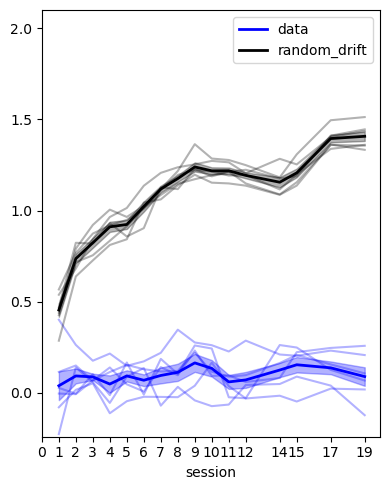

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,time,3.376819,15,75,0.225121,47.021136,6.345655e-32,1.041671e-08,0.695749,0.227647
1,condition,45.738094,1,5,45.738094,1709.995115,1.559909e-07,1.559909e-07,0.968724,1.000000
2,time * condition,2.422716,15,75,0.161514,46.183882,1.153329e-31,6.813123e-08,0.621305,0.202690


,Timepoint,Condition 1,Condition 2,Test Used,Statistic,p-value,Adjusted p-value (bonferroni),Significance,Effect Size,Effect Size Type,Mean Cond 1,Mean Cond 2,Mean Diff,SD Diff,N,Normal Dist.,Normality p-value
0,T1,C1,C2,wilcoxon,0.0000,0.0312,0.5000,,0.8987,r,0.0395,0.4547,-0.4151,0.1399,6,False,0.0049
1,T2,C1,C2,t-test,-9.6618,0.0002,0.0032,**,-3.9444,Cohen's d,0.0933,0.7366,-0.6432,0.1631,6,True,0.6815
2,T3,C1,C2,t-test,-23.5172,2.5882e-06,4.1411e-05,***,-9.6009,Cohen's d,0.0880,0.8234,-0.7355,0.0766,6,True,0.1851
3,T4,C1,C2,t-test,-27.3966,1.2124e-06,1.9398e-05,***,-11.1846,Cohen's d,0.0488,0.9110,-0.8621,0.0771,6,True,0.5206
4,T5,C1,C2,t-test,-19.8969,5.9251e-06,9.4801e-05,***,-8.1229,Cohen's d,0.0935,0.9239,-0.8304,0.1022,6,True,0.8991
5,T6,C1,C2,t-test,-36.7086,2.8250e-07,4.5200e-06,***,-14.9862,Cohen's d,0.0697,1.0224,-0.9527,0.0636,6,True,0.4516
6,T7,C1,C2,t-test,-32.3576,5.2965e-07,8.4744e-06,***,-13.2099,Cohen's d,0.0959,1.1184,-1.0225,0.0774,6,True,0.1615
7,T8,C1,C2,t-test,-26.3158,1.4809e-06,2.3694e-05,***,-10.7434,Cohen's d,0.1132,1.1758,-1.0625,0.0989,6,True,0.5239
8,T9,C1,C2,t-test,-24.1205,2.2825e-06,3.6519e-05,***,-9.8472,Cohen's d,0.1649,1.2394,-1.0745,0.1091,6,True,0.2584
9,T10,C1,C2,t-test,-24.2435,2.2256e-06,3.5609e-05,***,-9.8974,Cohen's d,0.1348,1.2180,-1.0832,0.1094,6,True,0.7032


,Source,SS,DF,MS,F,p-unc,ng2,eps
0,time,0.123312,15,0.008221,1.308204,0.218941,0.098329,0.230848
1,Error,0.471304,75,0.006284,NaN,NaN,NaN,NaN


,Source,SS,DF,MS,F,p-unc,ng2,eps
0,time,5.676223,15,0.378415,189.130702,3.642421e-53,0.942558,0.208027
1,Error,0.150061,75,0.002001,NaN,NaN,NaN,NaN


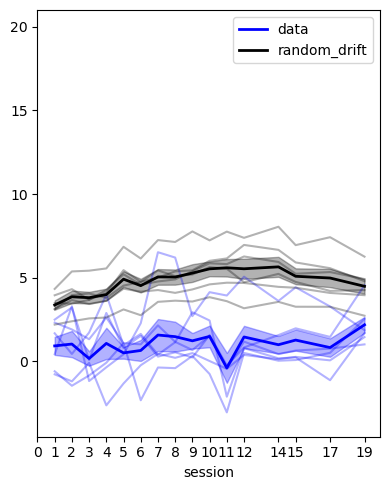

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,time,42.649001,15,75,2.843267,2.572639,0.003762,0.119981,0.099709,0.143152
1,condition,679.324807,1,5,679.324807,56.661981,0.000655,0.000655,0.638217,1.000000
2,time * condition,36.495439,15,75,2.433029,2.415231,0.006458,0.120529,0.086568,0.169790


,Timepoint,Condition 1,Condition 2,Test Used,Statistic,p-value,Adjusted p-value (bonferroni),Significance,Effect Size,Effect Size Type,Mean Cond 1,Mean Cond 2,Mean Diff,SD Diff,N,Normal Dist.,Normality p-value
0,T1,C1,C2,t-test,-4.9920,0.0041,0.0661,,-2.0380,Cohen's d,0.9281,3.3692,-2.4410,1.1978,6,True,0.8518
1,T2,C1,C2,t-test,-3.8911,0.0115,0.1842,,-1.5885,Cohen's d,1.0382,3.8626,-2.8244,1.7780,6,True,0.6742
2,T3,C1,C2,t-test,-8.9505,0.0003,0.0046,**,-3.6540,Cohen's d,0.1723,3.8082,-3.6359,0.9950,6,True,0.6624
3,T4,C1,C2,t-test,-3.1050,0.0267,0.4272,,-1.2676,Cohen's d,1.0767,3.9922,-2.9154,2.2999,6,True,0.7577
4,T5,C1,C2,t-test,-7.3472,0.0007,0.0117,*,-2.9995,Cohen's d,0.5104,4.9155,-4.4050,1.4686,6,True,0.5317
5,T6,C1,C2,wilcoxon,0.0000,0.0312,0.5000,,0.8987,r,0.6539,4.5280,-3.8741,1.3126,6,False,0.0298
6,T7,C1,C2,wilcoxon,1.0000,0.0625,1.0000,,0.8131,r,1.5773,5.0501,-3.4727,2.4936,6,False,0.0035
7,T8,C1,C2,t-test,-3.7498,0.0133,0.2127,,-1.5309,Cohen's d,1.4800,5.0398,-3.5598,2.3253,6,True,0.1304
8,T9,C1,C2,t-test,-5.8103,0.0021,0.0341,*,-2.3721,Cohen's d,1.2305,5.2797,-4.0492,1.7070,6,True,0.3238
9,T10,C1,C2,t-test,-6.4874,0.0013,0.0208,*,-2.6485,Cohen's d,1.4941,5.5321,-4.0380,1.5247,6,True,0.5763


,Source,SS,DF,MS,F,p-unc,ng2,eps
0,time,33.274061,15,2.218271,1.125407,0.349634,0.113062,0.1497
1,Error,147.831291,75,1.971084,NaN,NaN,NaN,NaN


,Source,SS,DF,MS,F,p-unc,ng2,eps
0,time,45.870379,15,3.058025,21.614554,2.657207e-21,0.269937,0.161648
1,Error,10.610993,75,0.141480,NaN,NaN,NaN,NaN


In [46]:
print_large('DPCA')
# Subspace geometry analysis
print_large('\n' + '='*50)
print_large('RM ANOVA: SUBSPACE angles')
print_large('='*50)
fig, ax = plt.subplots(figsize=(4, 5))
g = [data[0] for data in forward_data_pop_geometry_subspace]
simu_g = [data[1] for data in forward_data_pop_geometry_subspace]
plots.plot_average_geometry([g, simu_g], maps, colors=['b', 'k'], 
                          labels=['data', 'random_drift'], 
                          plot_individual=True, ylim=[-0.24, 2.1], ax=ax)
plt.show()  

print_large('\nTWO-WAY REPEATED ANOVA')
anova=st.repeated_measures_anova_general([np.vstack(g), np.vstack(simu_g)])
display(anova[0])
display(anova[1])
print_large('\nData: ONE-WAY RM ANOVA')
display(st.repeated_measures_anova_single_condition(np.vstack(g)))
print_large('\nRandom Drift: oNE-WAY RM ANOVA')
display(st.repeated_measures_anova_single_condition(np.vstack(simu_g)))

# Angles analysis
print_large('\n' + '='*50)
print_large('RM ANOVA: Edge angles')
print_large('='*50)
fig, ax = plt.subplots(figsize=(4, 5))
g = [data[0] for data in forward_data_pop_geometry_angles]
simu_g = [data[1] for data in forward_data_pop_geometry_angles]
plots.plot_average_geometry([g, simu_g], maps, colors=['b', 'k'], 
                          labels=['data', 'random_drift'], 
                          plot_individual=True, ylim=[-0.24, 2.1], ax=ax)
plt.show()  

print_large('\nTWO-WAY REPEATED ANOVA')
anova=st.repeated_measures_anova_general([np.vstack(g), np.vstack(simu_g)])
display(anova[0])
display(anova[1])
print_large('\nData:')
display(st.repeated_measures_anova_single_condition(np.vstack(g)))
print_large('\nRandom Drift:')
display(st.repeated_measures_anova_single_condition(np.vstack(simu_g)))

# Topology analysis
print_large('\n' + '='*50)
print_large('RM ANOVA: Persistent homology')
print_large('='*50)
fig, ax = plt.subplots(figsize=(4, 5))
g = [data[0] for data in forward_data_topology]
simu_g = [data[1] for data in forward_data_topology]
plots.plot_average_geometry([g, simu_g], maps, colors=['b', 'k'], 
                          labels=['data', 'random_drift'], 
                          plot_individual=True, ylim=[-4.5, 21], ax=ax)
plt.show()  

print_large('\nTWO-WAY REPEATED ANOVA')
anova=st.repeated_measures_anova_general([np.vstack(g), np.vstack(simu_g)])
display(anova[0])
display(anova[1])
print_large('\nData:')
display(st.repeated_measures_anova_single_condition(np.vstack(g)))
print_large('\nRandom Drift:')
display(st.repeated_measures_anova_single_condition(np.vstack(simu_g)))